# PolyaClassifier positive sampling test

**Purpose**: To investigate the effects of down-sampled positive sites on PolyaClassifier performance.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
import paper_utilities
from paper_utilities import models

from functools import reduce


In [5]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'polyaclassifier_model_positive_sampling_comparison')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


## HELPER FUNCTIONS

In [6]:
def compare_configuration(row, config):
    return all([(row[var] == config[var]) for var in config.keys()])


In [7]:
def compile_input_data(datapath, data_index, data_type, header = True):
    
    data = []
    
    with open(datapath, mode = 'r') as infile:
        if (header):
            infile.readline()
        for line in infile:
            data.append(data_type(line.rstrip("\n").split("\t")[data_index]))
            
    return data
        

    
def compile_prediction_dict(datapath, sequence_index, prediction_index, header = True):
    
    predictions = {}
    
    with open(datapath, mode = 'r') as infile:
        if (header):
            infile.readline()
        for line in infile:
            llist = line.rstrip("\n").split("\t")
            predictions[llist[sequence_index]] = float(llist[prediction_index])
            
    return predictions



def concatenate_aggregate_performance(models, data_desc, data_seeds, models_to_use = [], verbose = False):
    
    results   = {}
    counter   = 0
    
    ## Iterate over input data sets
    
    obs_classes  = []
    pred_classes = []

    for data_seed in data_seeds:
        
        ## Combine predictions
        
        sequences = compile_input_data(os.path.join(RESOURCES, 'polyaclassifier_sampling_test', f"{data_desc}_{data_seed}.polyaclassifier_{models_to_use[0]}.txt"), 9, str)
        reads     = compile_input_data(os.path.join(RESOURCES, 'polyaclassifier_sampling_test', f"{data_desc}_{data_seed}.polyaclassifier_{models_to_use[0]}.txt"), 6, float)
        classes   = (np.asarray(reads) > 0).astype(int)

        predictions = np.zeros((len(sequences),len(models_to_use)))

        for i,s in enumerate(models_to_use):
            sdict = compile_prediction_dict(os.path.join(RESOURCES, 'polyaclassifier_sampling_test', f"{data_desc}_{data_seed}.polyaclassifier_{s}.txt"), 9, 12)
            predictions[:,i] = np.asarray([sdict[seq] for seq in sequences])

        predictions = np.mean(predictions, axis = 1)
    
        ## Quality length of data lists
        
        if (len(list(set([len(sequences), len(reads), len(classes), len(predictions)]))) > 1):
            raise ValueError()

        ## Recalculate AUROC and AUPRC using mean predictions
    
        obs_classes.append(classes)
        pred_classes.append(predictions)
        
    obs_classes  = list(itertools.chain.from_iterable(obs_classes))
    pred_classes = list(itertools.chain.from_iterable(pred_classes))

    fpr, tpr, thresholds = roc_curve(obs_classes, pred_classes)
    auroc = auc(fpr, tpr)

    prec, rec, thresholds = precision_recall_curve(obs_classes, pred_classes)
    auprc = auc(rec, prec)

    results[counter] = {'model_stamps': models_to_use, 'negative_seed': data_seed, 'classification_AUROC': auroc, 'classification_AUPRC': auprc}
    counter += 1

    return pd.DataFrame.from_dict(results, orient = 'index')


In [8]:
def calculate_split_sites(datapath, split, posvar = None):
    
    counter = 0
    
    with open(datapath, mode = 'r') as handle:
        header = handle.readline().rstrip("\n").split("\t")
            
        for line in handle:
            ldict = dict(zip(header, line.rstrip("\n").split("\t")))
            
            if (ldict['split'] == split):
                if (posvar is None):
                    counter += 1
                elif (float(ldict[posvar]) > 0):
                    counter += 1
    
    return counter


In [9]:
def summarize_performance_by_training_size(models, test_nickname, subset_reads_list, data_seeds):
    
    subset_results = []

    for subset_reads in subset_reads_list:

        subset_data = models.loc[models['dataset'].str.contains(f'reads_{subset_reads}')]
        print(sorted(subset_data['training_sitesR'].unique()))

        for training_size in sorted(subset_data['training_sitesR'].unique()):

            subset_stamps = subset_data.loc[subset_data['training_sitesR'] == training_size, 'stamp'].tolist()
            print(f"Subset reads={subset_reads} size={training_size} stamps={','.join(subset_stamps)}")

            results = concatenate_aggregate_performance(subset_data,
                                                        f'{test_nickname}_possamp{subset_reads}_test_data', 
                                                        data_seeds, 
                                                        models_to_use = subset_stamps, verbose = False)

            results['subset_reads'] = subset_reads
            results['subset_size'] = training_size
            results['subset_size_div1000'] = training_size / 1000
            results['subset_size_log10'] = np.log10(training_size)

            subset_results.append(results)

    return pd.concat(subset_results, ignore_index = True, sort = False)


In [10]:
def visualize_performance_by_training_size(species, results, ylim = None, ytickint = 0.02, xlim = None, xtickint = 5, star_subset_reads = None, star_train_size = None):
    
    sres = results.sort_values('subset_size', ascending = True)
    
    ## AUROC
    
    fig,ax = plt.subplots(1,1, figsize = (1,1))

    ax.plot(sres['subset_size_div1000'], sres['classification_AUROC'], color = 'black', linewidth = 1, zorder = 1)
    ax.scatter(sres['subset_size_div1000'], sres['classification_AUROC'], color = 'black', s = 25, marker = '.', linewidths = 0, edgecolors = 'none', zorder = 1)

    if (star_subset_reads is not None) and (star_train_size is not None):
        star_y = sres.loc[(sres['subset_reads'] == star_subset_reads) & (sres['subset_size_div1000'] == star_train_size), 'classification_AUROC']
        ax.scatter(star_train_size, star_y, label = 'Final training size', marker = '*', s = 15, linewidths = 0.25, c = 'firebrick', zorder = 2)

    ax.set_xlabel("Training data size (x1000)")
    ax.set_ylabel("AUROC")

    ax.set_xticks(np.arange(xlim[0], xlim[1]+xtickint, xtickint, dtype = int))

    ax.yaxis.set_major_locator(MultipleLocator(ytickint))
    ax.set_ylim(ylim)
    
    ax.legend(bbox_to_anchor = (1.05,1))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig(os.path.join(OUTDIR, f'{species}.auroc_by_training_size.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    ## AUPRC
    
    fig,ax = plt.subplots(1,1, figsize = (1,1))

    ax.plot(sres['subset_size_div1000'], sres['classification_AUPRC'], color = 'black', linewidth = 1, zorder = 1)
    ax.scatter(sres['subset_size_div1000'], sres['classification_AUPRC'], color = 'black', s = 25, marker = '.', linewidths = 0, edgecolors = 'none', zorder = 1)

    if (star_subset_reads is not None) and (star_train_size is not None):
        star_y = sres.loc[(sres['subset_reads'] == star_subset_reads) & (sres['subset_size_div1000'] == star_train_size), 'classification_AUPRC']
        ax.scatter(star_train_size, star_y, label = 'Final training size', marker = '*', s = 15, linewidths = 0.25, c = 'firebrick', zorder = 2)

    ax.set_xlabel("Training data size (x1000)")
    ax.set_ylabel("AUPRC")

    ax.set_xticks(np.arange(xlim[0], xlim[1]+xtickint, xtickint, dtype = int))

    ax.yaxis.set_major_locator(MultipleLocator(ytickint))
    ax.set_ylim(ylim)
    
    ax.legend(bbox_to_anchor = (1.05,1))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig(os.path.join(OUTDIR, f'{species}.auprc_by_training_size.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    return


## ANALYSIS

### Saccharomyces cerevisiae

#### Train bagged models using subsets of the training data to investigate effect of training set size

In [11]:
scer_config = {
    'genomic_As'    : 'redistA',
    'architecture'  : 'classification',
    'sequence_size' : 500,
    'conv_units'    : 512,
    'lstm_units'    : 16,
    'conv_shape'    : 12,
    'bin_dropout'   : 0.5,
    'learning_rate' : 0.001,
}

scer_data_stamps  = ['74070','135795','197520']
scer_final_stamps = ["20240422-094557","20240422-094624","20240422-094653"]


#### Compile model performance summaries and tabulate the number of training sites

In [12]:
scer_data = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_replicate_summary.saccharomyces_cerevisiae.txt'), sep = "\t")
scer_data = scer_data.loc[scer_data.apply(lambda row : compare_configuration(row, scer_config), axis = 1) & ((scer_data['modeltype'] == 'special_pstest') | (scer_data['stamp'].isin(scer_final_stamps)))]
print(scer_data.shape)


(48, 21)


In [13]:
scer_data['training_sites'] = scer_data['dataset'].apply(lambda x : calculate_split_sites(x, 'train'))


In [14]:
scer_data.loc[scer_data['dataset'].str.contains("reads_5") == True,  'threshold_reads'] = 5
scer_data.loc[scer_data['dataset'].str.contains("reads_10") == True, 'threshold_reads'] = 10

reads5_max_training  = scer_data.loc[scer_data['threshold_reads'] ==  5].sort_values('training_sites', ascending = False)['stamp'].head(3).tolist()
reads10_max_training = scer_data.loc[scer_data['threshold_reads'] == 10].sort_values('training_sites', ascending = False)['stamp'].head(3).tolist()


In [15]:
scer_data['training_sitesR'] = scer_data['training_sites']
scer_data.loc[scer_data['stamp'].isin(reads5_max_training),  'training_sitesR'] = scer_data.loc[scer_data['stamp'].isin(reads5_max_training),  'training_sites'].mean()
scer_data.loc[scer_data['stamp'].isin(reads10_max_training), 'training_sitesR'] = scer_data.loc[scer_data['stamp'].isin(reads10_max_training), 'training_sites'].mean()

scer_data['training_sitesR_log10'] = np.log10(scer_data['training_sitesR'])


In [16]:
cond5MAX = (scer_data['threshold_reads'] == 5) & (scer_data['training_sitesR'] == scer_data.loc[scer_data['stamp'].isin(reads5_max_training),  'training_sites'].mean())
cond10ALL = (scer_data['threshold_reads'] == 10)

scer_filt = scer_data.loc[cond5MAX | cond10ALL].copy()
print(cond5MAX.sum(), cond10ALL.sum(), scer_filt.shape)


3 24 (27, 25)


#### Calculate the performance of the "bagged" models using the average of multiple predictions

In [17]:
scer_results = summarize_performance_by_training_size(scer_filt, 'scer', [5,10], ['12345'])


[86537.66666666667]
Subset reads=5 size=86537.66666666667 stamps=20240424-010137,20240424-010144,20240424-010147
[1000.0, 2000.0, 4000.0, 10000.0, 20000.0, 40000.0, 60000.0, 64689.0]
Subset reads=10 size=1000.0 stamps=20240424-010155,20240424-010223,20240424-010253
Subset reads=10 size=2000.0 stamps=20240424-010201,20240424-010235,20240424-010303
Subset reads=10 size=4000.0 stamps=20240424-010209,20240424-010243,20240424-010309
Subset reads=10 size=10000.0 stamps=20240424-010150,20240424-010217,20240424-010250
Subset reads=10 size=20000.0 stamps=20240424-010159,20240424-010228,20240424-010257
Subset reads=10 size=40000.0 stamps=20240424-010204,20240424-010240,20240424-010306
Subset reads=10 size=60000.0 stamps=20240424-010212,20240424-010248,20240424-010314
Subset reads=10 size=64689.0 stamps=20240422-094557,20240422-094624,20240422-094653


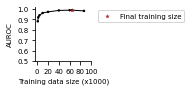

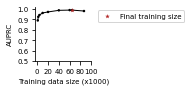

In [18]:
visualize_performance_by_training_size('saccharomyces_cerevisiae', scer_results, 
                                       xlim = (0, 90), xtickint = 20,
                                       ylim = (0.5,1.02), ytickint = 0.1,
                                       star_subset_reads = 10, star_train_size = scer_results.loc[scer_results['subset_reads'] == 10, 'subset_size_div1000'].max()
                                      )


### Schizosaccharomyces pombe

#### Train bagged models using subsets of the training data to investigate effect of training set size

In [19]:
spom_config = {
    'genomic_As'    : 'redistA',
    'architecture'  : 'classification1',
    'sequence_size' : 500,
    'conv_units'    : 512,
    'lstm_units'    : 16,
    'conv_shape'    : 6,
    'bin_dropout'   : 0.5,
    'learning_rate' : 0.001,
}

spom_data_stamps  = ['49380','74070','197520']
spom_final_stamps = ['20240422-094802', '20240422-094812', '20240422-094843']


#### Compile model performance summaries and tabulate the number of training sites

In [20]:
spom_data = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_replicate_summary.schizosaccharomyces_pombe.txt'), sep = "\t")
spom_data = spom_data.loc[spom_data.apply(lambda row : compare_configuration(row, spom_config), axis = 1) & ((spom_data['modeltype'] == 'special_pstest') | (spom_data['stamp'].isin(spom_final_stamps)))]
print(spom_data.shape)


(33, 21)


In [21]:
spom_data['training_sites'] = spom_data['dataset'].apply(lambda x : calculate_split_sites(x, 'train'))


In [22]:
spom_data.loc[spom_data['dataset'].str.contains("reads_5")  == True, 'threshold_reads'] = 5
spom_data.loc[spom_data['dataset'].str.contains("reads_10") == True, 'threshold_reads'] = 10

reads5_max_training  = spom_data.loc[spom_data['threshold_reads'] ==  5].sort_values('training_sites', ascending = False)['stamp'].head(3).tolist()
reads10_max_training = spom_data.loc[spom_data['threshold_reads'] == 10].sort_values('training_sites', ascending = False)['stamp'].head(3).tolist()


In [23]:
spom_data['training_sitesR'] = spom_data['training_sites']
spom_data.loc[spom_data['stamp'].isin(reads5_max_training),  'training_sitesR'] = spom_data.loc[spom_data['stamp'].isin(reads5_max_training),  'training_sites'].mean()
spom_data.loc[spom_data['stamp'].isin(reads10_max_training), 'training_sitesR'] = spom_data.loc[spom_data['stamp'].isin(reads10_max_training), 'training_sites'].mean()

spom_data['training_sitesR_log10'] = np.log10(spom_data['training_sitesR'])


In [24]:
cond10MAX = (spom_data['threshold_reads'] == 10) & (spom_data['training_sitesR'] == spom_data.loc[spom_data['stamp'].isin(reads10_max_training), 'training_sites'].mean())
cond5ALL = (spom_data['threshold_reads'] == 5)

spom_filt = spom_data.loc[cond5ALL | cond10MAX].copy()
print(cond5ALL.sum(), cond10MAX.sum(), spom_filt.shape)


18 3 (21, 25)


#### Calculate the performance of the "bagged" models using the average of multiple predictions

In [25]:
spom_results = summarize_performance_by_training_size(spom_filt, 'spom', [5,10], ['12345'])


[1000.0, 2000.0, 4000.0, 10000.0, 20000.0, 20292.333333333332]
Subset reads=5 size=1000.0 stamps=20240424-010535,20240424-010605,20240424-010621
Subset reads=5 size=2000.0 stamps=20240424-010546,20240424-010611,20240424-010630
Subset reads=5 size=4000.0 stamps=20240424-010549,20240424-010616,20240424-010632
Subset reads=5 size=10000.0 stamps=20240424-010532,20240424-010552,20240424-010619
Subset reads=5 size=20000.0 stamps=20240424-010540,20240424-010609,20240424-010626
Subset reads=5 size=20292.333333333332 stamps=20240422-094802,20240422-094812,20240422-094843
[13021.0]
Subset reads=10 size=13021.0 stamps=20240424-010435,20240424-010441,20240424-010443


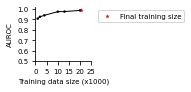

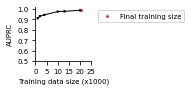

In [26]:
visualize_performance_by_training_size('schizosaccharomyces_pombe', spom_results, 
                                       xlim = (0, 25), xtickint = 5,
                                       ylim = (0.5,1.02), ytickint = 0.1,
                                       star_subset_reads = 5, star_train_size = spom_results.loc[spom_results['subset_reads'] == 5, 'subset_size_div1000'].max()
                                      )


### Arabidopsis thaliana

#### Train bagged models using subsets of the training data to investigate effect of training set size

In [27]:
atha_config = {
    'genomic_As'    : 'redistA',
    'architecture'  : 'classification2',
    'sequence_size' : 500,
    'conv_units'    : 512,
    'lstm_units'    : 16,
    'conv_shape'    : 10,
    'bin_dropout'   : 0.5,
    'learning_rate' : 0.001,
}

atha_data_stamps  = ['37035','148140','209865']
atha_final_stamps = ['20240422-094938', '20240422-094958', '20240422-095014']


#### Compile model performance summaries and tabulate the number of training sites

In [28]:
atha_data = pd.read_csv(os.path.join(RESOURCES, 'polyaclassifier_replicate_summary.arabidopsis_thaliana.txt'), sep = "\t")
atha_data = atha_data.loc[atha_data.apply(lambda row : compare_configuration(row, atha_config), axis = 1) & ((atha_data['modeltype'] == 'special_pstest') | (atha_data['stamp'].isin(atha_final_stamps)))]
print(atha_data.shape)


(51, 21)


In [29]:
atha_data['training_sites'] = atha_data['dataset'].apply(lambda x : calculate_split_sites(x, 'train'))


In [30]:
atha_data.loc[atha_data['dataset'].str.contains("reads_5")  == True, 'threshold_reads'] = 5
atha_data.loc[atha_data['dataset'].str.contains("reads_10") == True, 'threshold_reads'] = 10

reads5_max_training  = atha_data.loc[atha_data['threshold_reads'] ==  5].sort_values('training_sites', ascending = False)['stamp'].head(3).tolist()
reads10_max_training = atha_data.loc[atha_data['threshold_reads'] == 10].sort_values('training_sites', ascending = False)['stamp'].head(3).tolist()


In [31]:
atha_data['training_sitesR'] = atha_data['training_sites']
atha_data.loc[atha_data['stamp'].isin(reads5_max_training),  'training_sitesR'] = atha_data.loc[atha_data['stamp'].isin(reads5_max_training),  'training_sites'].mean()
atha_data.loc[atha_data['stamp'].isin(reads10_max_training), 'training_sitesR'] = atha_data.loc[atha_data['stamp'].isin(reads10_max_training), 'training_sites'].mean()

atha_data['training_sitesR_log10'] = np.log10(atha_data['training_sitesR'])


In [32]:
cond5MAX = (atha_data['threshold_reads'] == 5) & (atha_data['training_sitesR'] == atha_data.loc[atha_data['stamp'].isin(reads5_max_training),  'training_sites'].mean())
cond10ALL = (atha_data['threshold_reads'] == 10)

atha_filt = atha_data.loc[cond5MAX | cond10ALL].copy()
print(cond5MAX.sum(), cond10ALL.sum(), atha_filt.shape)


3 24 (27, 25)


#### Calculate the performance of the "bagged" models using the average of multiple predictions

In [33]:
atha_results = summarize_performance_by_training_size(atha_filt, 'atha', [5,10], [12345])


[109187.66666666667]
Subset reads=5 size=109187.66666666667 stamps=20240424-010635,20240424-010637,20240424-010640
[1000.0, 2000.0, 4000.0, 10000.0, 20000.0, 40000.0, 60000.0, 76271.66666666667]
Subset reads=10 size=1000.0 stamps=20240424-010645,20240424-010701,20240424-010729
Subset reads=10 size=2000.0 stamps=20240424-010649,20240424-010705,20240424-010738
Subset reads=10 size=4000.0 stamps=20240424-010654,20240424-010717,20240424-010746
Subset reads=10 size=10000.0 stamps=20240424-010642,20240424-010658,20240424-010724
Subset reads=10 size=20000.0 stamps=20240424-010647,20240424-010703,20240424-010735
Subset reads=10 size=40000.0 stamps=20240424-010651,20240424-010710,20240424-010742
Subset reads=10 size=60000.0 stamps=20240424-010656,20240424-010720,20240424-010752
Subset reads=10 size=76271.66666666667 stamps=20240422-094938,20240422-094958,20240422-095014


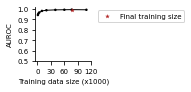

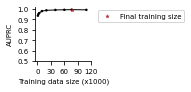

In [34]:
visualize_performance_by_training_size('arabidopsis_thaliana', atha_results, 
                                       xlim = (0, 120), xtickint = 30,
                                       ylim = (0.5,1.02), ytickint = 0.1,
                                       star_subset_reads = 10, star_train_size = atha_results.loc[atha_results['subset_reads'] == 10, 'subset_size_div1000'].max()
                                      )
